# GRADIENT BOOSTING

Comenzamos importando todas aquellas librerías y funciones que vamos a utilizar a lo largo de la práctica:

In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

A continuación, se definen tres funciones: *createDataSet()*, *plotModel()* y *plotData()*. Las utilizaremos para implementar el algoritmo de *gradient boosting*.

In [12]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [13]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [14]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

El algoritmo del *gradient boosting* es una técnica de aprendizaje automático a partir del cuál se consigue establecer un modelo predictivo mediante un conjunto de árboles de decisión entrenados de forma individual.

Dicho algoritmo, desde un punto de vista general, se encarga de encontrar una función $F$, que minimice la esperanza de la función $L(y,F(\boldsymbol{x}))$, es decir, de encontrar un $\hat{F}$ tal que

$$
\hat{F} = arg\min_F E_{\boldsymbol{x},y}[L(y,F(\boldsymbol{x}))] = arg\min_F \sum_{i=1}^N L(y_i,F(\boldsymbol{x}_i))
$$

para el conjunto de datos de entrenamiento $D = \{(\boldsymbol{x}_i,y_i)\}_{i=1}^N$.

Esta función $F$, se construye en base al modelo iterativo

$$
F_t(\boldsymbol{x}) = F_{t-1}(\boldsymbol{x}) + \rho_t h_t(\boldsymbol{x})
$$

siendo

$$
F_0 = \argmin_{\gamma} \sum_{i=1}^N L(y_i,\gamma)
$$

para todo parámetro real $\gamma$. 


Este algoritmo se va a implementar para regresión y para clasificación binaria con clases igual a $-1$ y $+1$.

De este modo, vamos a definir dos clases correspondientes para cada implementación, donde se vamos a definir los parámetros que se van a utilizar respectivamente.

En primer lugar, para regresión vamos a considerar los siguiente:

Parámetro de inicialización:
$$
F_0 = \frac{1}{N}\sum_{i = 1}^N y_i
$$

Residuos:
$$
r_{ti} = y_i - F_{t-1}(\boldsymbol{x_i})
$$

Multiplicador:
$$
\rho_t=1
$$


In [15]:

class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y): 
        """ Calcula el valor constate que minimiza la salida 'y' """
        return mean(y)

    def residuos(_,y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return  y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        return valor
        
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2
    
    def predict_salida(self, y):
        """ Devuelve el valor salida correspondiente a la predicción de los
            valores X"""
        return y

Por otro lado, para la implementación correspondiente a la clasificación binaria, consideraremos lo siguiente:

Parámetro de inicialización:
$$
F_0 = \frac{1}{2} \log\left(\frac{1+\overline{y}}{1-\overline{y}}\right)
$$

Residuos:
$$
r_{ti}=\frac{2y_i}{1+e^{2y_iF_{t-1}(\boldsymbol(x_i))}}
$$

Multiplicador:
$$
\rho_{tj} = \frac{\sum_{\boldsymbol{x}_i\in R_j}r_{ti}}{\sum_{\boldsymbol{x}_i\in R_j}|r_{ti}|(2-|r_{ti}|)}
$$

In [16]:
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return 0.5*np.log((1+np.mean(y))/(1-np.mean(y)))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return 2*y/(1+np.exp(2*y*F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        return sum(residuos)/sum((np.abs(residuos))*(2-np.abs(residuos)))
    
    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))
    
    def predict_salida(self, y):
        """ Devuelve el valor salida correspondiente a la predicción de los
            valores X"""
        trans_y = 1 / (1 + np.exp(-2.0*y))
        if trans_y >= 0.5:
            return y
        else:
            return -y

Por último, crearemos una tercera clase, donde se llevará a cabo la implementación del algoritmo, desde un punto de vista general. Se seguirán los siguientes pasos:

1. Inicializaremos la función constante de inicialización $F_0$
2. Para $i=1$ hasta el tamaño del conjunto, $T$:
    
    I. Calcularemos los residuos $r_{ti}$.

    II. Ajustaremos un regresor $h(\boldsymbol{x})$ correspondiente al dataset $\{(\boldsymbol{x}_i,r_{ti})\}_{i=1}^N$.

    III. Calcularemos los multiplicadores $\rho_{t}$, mediante el método del paso Newton-Raphson.
    
    IV. Actualizaremos el modelo, a partir de la fórmula recursiva

    $$
    F_t(\boldsymbol{x}) = F_{t-1}(\boldsymbol{x}) + \rho_t h_t(\boldsymbol{x}).
    $$




In [17]:
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        #1. Inicializamos con un valor constante
        self.F0 = self.loss.F0(X,y)
        
        #2. Para i=1 hasta el tamaño del conjunto T = self.n_estimators
        for i in range(self.n_estimators):
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            #I. Calculamos los residuos para cada iteración
            residuals = self.loss.residuos(y,self.predict(X))
            #II. Ajustamos un regresor h(X) al dataset
            tree = DecisionTreeRegressor(max_depth = self.depth)
            tree.fit(X,y)
            #III. Computamos el multiplicador con un paso Newton-Raphson 
            self.paso_newton_general(tree,X,y,residuals)
            #Actualizamos el modelo
            self._estimators.append(tree)
            
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida' o
             predicciones en crudo, y que haga:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable 
                  
            Nota1: Podéis delegar esto a las funciones de pérdida para evitar 
                   poner aquí in if
            Nota2: Podéis también organizar la clasificacion/regresion al estilo
                   sklearn e implementar predict_proba en la clasificación.
                
        """
        
        result=np.array([self.F0])
        for est in self._estimators:
            np.append(result,self.eta*est.predict(X))
        return self.loss.predict_salida(sum(result))
    
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])

    


Ahora vamos a realizar una serie de pruebas para ambas implementaciones del algoritmo. Para lo cuál, comenzarmos definiendo los datos que vamos a utilizar:

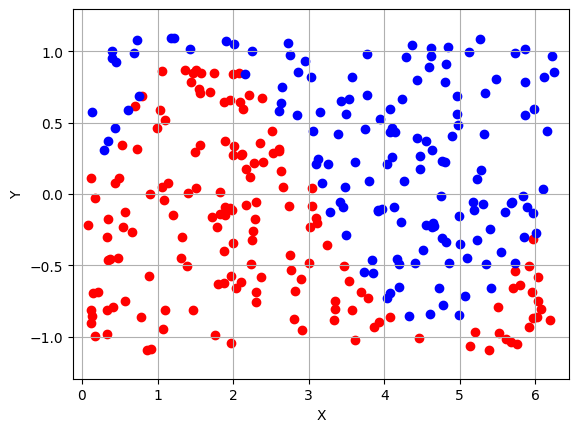

In [18]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)

x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
Xtrain = np.concatenate((x1, x2), axis = 1)

x1test, x2test, ytest      = createDataSet(n*10, model, ymargin, noise)
Xtest = np.concatenate((x1test, x2test), axis = 1)

plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})

In [19]:
from sklearn.preprocessing import LabelBinarizer

# Basic example
gb = GBCasero(loss=LogLoss())

lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
ytrain = lb.fit_transform(ytrain).ravel()
ytest  = lb.transform(ytest).ravel()

gb.fit(Xtrain, ytrain)
acc = np.sum(gb.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,gb,"Acc="+str(acc))

# Magic
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GBCasero(loss=LogLoss())

gb.fit(X_tr, y_tr)
print("Accuracy in Magic04=",np.sum(gb.predict(X_ts)==y_ts)/len(y_ts))

# Incluir aquí pruebas para regresión con la pérdida cuadrática


ValueError: cannot reshape array of size 1 into shape (100,100)